In [1]:
!pip install psycopg2-binary

  Obtaining dependency information for psycopg2-binary from https://files.pythonhosted.org/packages/bc/0d/486e3fa27f39a00168abfcf14a3d8444f437f4b755cc34316da1124f293d/psycopg2_binary-2.9.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.8 MB/s eta 0:00:0000:0100:01


In [2]:
import re
import string
import os
import gc
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime as dt

from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from catboost import CatBoostClassifier
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sqlalchemy.engine.base import Engine
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import BertModel
from transformers import DataCollatorWithPadding
from tqdm import tqdm
from yaml import safe_load

from database.database import engine
from config.config import PG_USER, PG_PASS, PG_HOST, PG_PORT, PG_DB


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def select(query: str, conn: Engine=engine) -> pd.DataFrame:
    return pd.read_sql(query, conn)
    
users_query = "SELECT * FROM public.user_data"
posts_query = "SELECT * FROM public.post_text_df"
feeds_query = "SELECT * FROM public.feed_data WHERE action = 'view' LIMIT 5000000"

users_df = select(users_query)
posts_df = select(posts_query)
feeds_df = select(feeds_query)

In [4]:
# posts_df.to_parquet("./postgres/init_data/posts.parquet")
# users_df.to_parquet("./postgres/init_data/users.parquet")
# feeds_df.to_parquet("./postgres/init_data/feeds.parquet")

# posts_df.to_csv("./postgres/init_data/posts.csv", sep = ",", index = False)
# users_df.to_csv("./postgres/init_data/users.csv", sep = ",", index = False)
# feeds_df.to_csv("./postgres/init_data/feeds.csv", sep = ",", index = False)  

In [5]:
users_df.shape, posts_df.shape, feeds_df.shape

((163205, 8), (7023, 3), (5000000, 5))

In [6]:
posts_df.head(2)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufacturing sector will continue to face serious chall...,business
1,2,Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the l...,business


In [7]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [8]:
class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])

In [9]:
dataset = PostDataset(posts_df['text'].values.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [10]:
@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [11]:
embeddings = get_embeddings_labels(model, loader).numpy()

centered = embeddings - embeddings.mean()

pca = PCA(n_components=50)
pca_decomp = pca.fit_transform(centered)

100%|██████████| 220/220 [03:53<00:00,  1.06s/it]


In [12]:
n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_decomp)

posts_df['TextCluster'] = kmeans.labels_

dists_columns = [f'DistanceTo{i+1}thCluster' for i in range(n_clusters)]

kmeans_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

kmeans_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,6.323307,5.767722,5.163037,6.867918,5.685260,5.763680,6.418237,5.696512,6.826219,4.854681,4.760907,5.726633,6.551126,6.146155,6.335970,5.742432,4.799216,6.250274,3.629120,6.481100
1,6.857339,5.289181,2.518361,6.036397,5.514640,3.371709,6.456307,5.232178,5.735745,4.838624,2.986342,5.790180,6.306622,6.476357,5.037056,4.418316,4.652786,5.685310,3.846382,3.538840
2,6.403342,4.993618,2.721426,5.913885,5.146860,4.036148,6.020407,5.091903,5.605210,4.779217,3.788994,5.374900,5.770377,6.205044,4.671967,4.329899,4.671478,5.169789,3.410821,4.166090
3,7.541594,6.631639,3.830333,6.480829,5.962891,3.245614,7.340622,5.641706,5.941847,5.400392,4.829945,6.618314,6.818136,7.225009,5.325978,5.482270,5.909707,6.500913,5.877015,2.119342
4,6.142992,5.468961,3.776452,5.368492,4.596586,3.113434,5.832508,4.850903,4.876090,4.392369,4.307158,5.263593,5.765942,5.922513,4.038109,4.617361,5.222190,5.010290,5.000598,2.653202


In [13]:
posts_df = pd.concat((posts_df,kmeans_df),axis=1)
# posts_df.to_parquet("./postgres/init_data/processed_posts.parquet")
# posts_df.to_csv("./postgres/init_data/processed_posts.csv", sep = ",", index = False)
posts_df.head(2)

,post_id,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,1,UK economy facing major risks\n\nThe UK manufacturing sector will continue to face serious chall...,business,18,6.323307,5.767722,5.163037,6.867918,5.68526,5.763680,6.418237,5.696512,6.826219,4.854681,4.760907,5.726633,6.551126,6.146155,6.335970,5.742432,4.799216,6.250274,3.629120,6.48110
1,2,Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the l...,business,2,6.857339,5.289181,2.518361,6.036397,5.51464,3.371709,6.456307,5.232178,5.735745,4.838624,2.986342,5.790180,6.306622,6.476357,5.037056,4.418316,4.652786,5.685310,3.846382,3.53884


In [14]:
posts_df.to_sql(
   "posts_info_by_radion_nazmiev",
    con=engine,
    schema="public",
    if_exists='replace'
)

23

In [15]:
del users_query
del posts_query
del feeds_query
del centered
del pca
del pca_decomp
del kmeans
del dists_columns
del kmeans_df
del PCA
del KMeans

gc.collect()

351

In [16]:
df = pd.merge(
    feeds_df,
    posts_df,
    on='post_id',
    how='inner'
)
df = pd.merge(
    users_df,
    df,
    on='user_id',
    how='inner'
)

df.shape

(5000000, 35)

In [17]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

del feeds_df
del posts_df
del users_df

df = df.set_index(['user_id', 'post_id'])

df.head(2)

gender  age country     city  exp_group       os source  \
user_id post_id                                                            
6578    2901          0   28  Russia  Kolpino          3  Android    ads   
        6956          0   28  Russia  Kolpino          3  Android    ads   

                          timestamp action  target  \
user_id post_id                                      
6578    2901    2021-10-09 17:34:26   view       0   
        6956    2021-10-09 16:50:14   view       0   

                                                                                                                text  \
user_id post_id                                                                                                        
6578    2901     With the release of #JobKeeper3.0 some of the eligibility rules have changed.\nThe relevant date...   
        6956     I just watched this movie at the Santo Domingo International Film Festival. While watching the m...   

                 topic  TextCluster  DistanceTo1thCluster  \
user_id post_id                                             
6578    2901     covid           14              4.986865   
        6956     movie           12              4.724984   

                 DistanceTo2thCluster  DistanceTo3thCluster  \
user_id post_id                                               
6578    2901                 4.854533              4.898827   
        6956                 5.627934              7.104073   

                 DistanceTo4thCluster  DistanceTo5thCluster  \
user_id post_id                                               
6578    2901                 2.877774              4.376638   
        6956                 6.768757              4.962933   

                 DistanceTo6thCluster  DistanceTo7thCluster  \
user_id post_id                                               
6578    2901                 5.087729              4.744865   
        6956                 7.149798              5.415495   

                 DistanceTo8thCluster  DistanceTo9thCluster  \
user_id post_id                                               
6578    2901                 4.861304              2.337799   
        6956                 5.555726              6.498417   

                 DistanceTo10thCluster  DistanceTo11thCluster  \
user_id post_id                                                 
6578    2901                  4.693180               5.275302   
        6956                  6.194727               7.221791   

                 DistanceTo12thCluster  DistanceTo13thCluster  \
user_id post_id                                                 
6578    2901                  4.247999               5.161055   
        6956                  5.305946               2.994125   

                 DistanceTo14thCluster  DistanceTo15thCluster  \
user_id post_id                                                 
6578    2901                  4.785689               1.586893   
        6956                  5.203775               6.191464   

                 DistanceTo16thCluster  DistanceTo17thCluster  \
user_id post_id                                                 
6578    2901                  4.788465               5.323091   
        6956                  5.872906               6.631752   

                 DistanceTo18thCluster  DistanceTo19thCluster  \
user_id post_id                                                 
6578    2901                  2.899087               4.530087   
        6956                  6.043728               6.228373   

                 DistanceTo20thCluster  hour  month  
user_id post_id                                      
6578    2901                  5.556858    17     10  
        6956                  7.760866    16     10

In [18]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:05:25'))

In [19]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop(['timestamp','action', 'text'], axis=1)
df_test = df_test.drop(['timestamp','action', 'text'], axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']
del df
del df_train
del df_test

y_train.shape, y_test.shape

((4164246,), (835754,))

In [20]:
object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]


cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)


pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [0, 30, 5, 6]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [7, 8, 2, 3, 4, 29])])),
                ('decision_tree', DecisionTreeClassifier())])

In [21]:
print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9503232353549971
Качество на тесте: 0.5284903116582184


In [22]:
catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2,
                              random_seed=100)

catboost.fit(X_train, y_train, object_cols, logging_level='Verbose')

0:	learn: 0.3597022	total: 1.68s	remaining: 2m 46s
1:	learn: 0.3516524	total: 3.36s	remaining: 2m 44s
2:	learn: 0.3497595	total: 5.24s	remaining: 2m 49s
3:	learn: 0.3489880	total: 6.56s	remaining: 2m 37s
4:	learn: 0.3483546	total: 7.9s	remaining: 2m 30s
5:	learn: 0.3481337	total: 9.2s	remaining: 2m 24s
6:	learn: 0.3479859	total: 10.5s	remaining: 2m 19s
7:	learn: 0.3470860	total: 11.7s	remaining: 2m 14s
8:	learn: 0.3466351	total: 13s	remaining: 2m 10s
9:	learn: 0.3465766	total: 14.2s	remaining: 2m 7s
10:	learn: 0.3465221	total: 15.4s	remaining: 2m 4s
11:	learn: 0.3461910	total: 16.7s	remaining: 2m 2s
12:	learn: 0.3461740	total: 17.8s	remaining: 1m 59s
13:	learn: 0.3461238	total: 19s	remaining: 1m 56s
14:	learn: 0.3460692	total: 20.2s	remaining: 1m 54s
15:	learn: 0.3460465	total: 21.4s	remaining: 1m 52s
16:	learn: 0.3460179	total: 22.5s	remaining: 1m 49s
17:	learn: 0.3458952	total: 23.8s	remaining: 1m 48s
18:	learn: 0.3458352	total: 25s	remaining: 1m 46s
19:	learn: 0.3455895	total: 26.2s

In [23]:
print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6618656819123357
Качество на тесте: 0.6442796952339209


In [24]:
catboost.save_model('catboost_model')

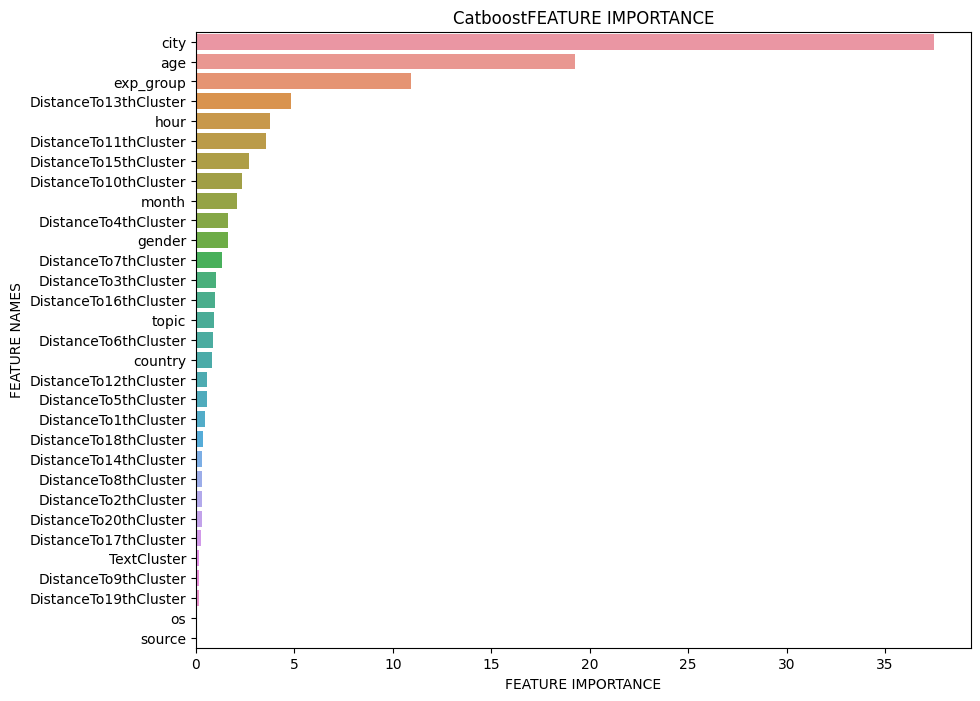

In [25]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')